In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import sys
sys.path.append('/code/')
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg

import seaborn as sns
import scipy.ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

%matplotlib inline

In [3]:
results_dir = '../../results'

In [4]:
cells_df = abc.get_combined_metadata(drop_unused=False)
print(f'n_cells in the whole-brain ABC Atlas: {cells_df.shape[0]}')

n_cells in the whole-brain ABC Atlas: 3739961


In [5]:
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [6]:
obs_th

,brain_section_label,cluster_alias,average_correlation_score,x_section,y_section,z_section,neurotransmitter,class,subclass,supertype,...,y_reconstructed,z_reconstructed,parcellation_index,x_ccf,y_ccf,z_ccf,parcellation_division,parcellation_structure,parcellation_substructure,left_hemisphere
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171907102970225,C57BL6J-638850.37,3155,0.515042,6.852032,6.459106,6.6,GABA,20 MB GABA,197 SNr Six3 Gaba,0806 SNr Six3 Gaba_1,...,6.449028,6.6,787,7.204802,5.184069,7.025149,HY,ZI,ZI,False
1018093344102600178-2,C57BL6J-638850.36,3155,0.505055,7.165970,6.029406,6.4,GABA,20 MB GABA,197 SNr Six3 Gaba,0806 SNr Six3 Gaba_1,...,6.043638,6.4,787,7.442089,4.742288,7.413300,HY,ZI,ZI,False
1018093344102510506-4,C57BL6J-638850.35,3155,0.513099,4.000065,6.243119,6.2,GABA,20 MB GABA,197 SNr Six3 Gaba,0806 SNr Six3 Gaba_1,...,6.141358,6.2,787,7.521666,4.787502,4.114865,HY,ZI,ZI,True
1018093344101270649-4,C57BL6J-638850.35,3155,0.532766,7.250921,5.934243,6.2,GABA,20 MB GABA,197 SNr Six3 Gaba,0806 SNr Six3 Gaba_1,...,5.870733,6.2,787,7.643785,4.558091,7.480014,HY,ZI,ZI,False
1018093344101260179-5,C57BL6J-638850.35,3155,0.500081,7.894927,5.491519,6.2,GABA,20 MB GABA,197 SNr Six3 Gaba,0806 SNr Six3 Gaba_1,...,5.449421,6.2,787,7.708838,4.089740,8.076068,HY,ZI,ZI,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019171907102620076-1,C57BL6J-638850.43,1795,0.522174,7.656792,5.425699,7.8,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0435 RT-ZI Gnb3 Gaba_5,...,5.452669,7.8,255,6.259863,4.049802,7.914735,TH,RT,RT,False
1020131842101890882,C57BL6J-638850.44,1796,0.539159,4.267835,5.462476,8.0,GABA,12 HY GABA,093 RT-ZI Gnb3 Gaba,0433 RT-ZI Gnb3 Gaba_3,...,5.400828,8.0,255,5.987269,3.905449,4.298174,TH,RT,RT,True
1018093344102470409-5,C57BL6J-638850.33,5066,0.510517,7.937806,5.487021,5.8,Glut,18 TH Glut,151 TH Prkcd Grin2c Glut,0654 TH Prkcd Grin2c Glut_1,...,5.033061,5.8,1285,8.120927,3.641178,8.228527,TH,LGd,LGd-sh,False


In [7]:
print(len(obs_th[obs_th['class'].isin(['12 HY GABA', '17 MH-LH Glut', '18 TH Glut'])]) / len(obs_th) * 100)

94.14462214810885


In [8]:
print(len(obs_th[obs_th['class']=='19 MB Glut']) / len(obs_th) * 100)
print(len(obs_th[obs_th['class']=='20 MB GABA']) / len(obs_th) * 100)

3.5005937492104398
2.3547841026807146


### Set up data structures for figure

In [9]:
cells_df_th_subset = abc.label_thalamus_spatial_subset(cells_df,
                                                       distance_px=20,
                                                       cleanup_mask=True,
                                                       drop_end_sections=True,
                                                       filter_cells=True)

In [10]:
# loads the whole-brain CCF resampled_annotation image volumes
ccf_img = abc.get_ccf_labels_image(resampled=True)

# get all parcellation names that are in either TH or ZI
ccf_regions_to_select = ['TH', 'ZI'] # TH = thalamus ; ZI = zona incerta
ccf_regions = abc.get_ccf_names(top_nodes=ccf_regions_to_select, 
                                level='substructure')
print(f'{ccf_regions=}')

# convert parcellation names to the unique parcellation_index used in the image volume
ccf_index = abc.get_ccf_index(level='substructure')
reverse_lookup = pd.Series(ccf_index.index.values, index=ccf_index)
th_zi_index_values = reverse_lookup.loc[ccf_regions]
print(f'{th_zi_index_values[:5]=} \netc. ...')

# generate a binary TH+ZI mask
th_zi_mask = np.isin(ccf_img, th_zi_index_values)

# subset the ccf image volume using the binary mask
th_zi_img = np.where(th_zi_mask, ccf_img, 0)

# 20px=200um
th_zi_mask_dilated = abc.sectionwise_dilation(th_zi_mask, distance_px=20)

ccf_regions=['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'Eth', 'FF', 'IAD', 'IAM', 'IGL', 'IMD', 'IntG', 'LD', 'LGd-co', 'LGd-ip', 'LGd-sh', 'LGv', 'LH', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL', 'PO', 'POL', 'PP', 'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT', 'SGN', 'SMT', 'SPA', 'SPFm', 'SPFp', 'SubG', 'TH-unassigned', 'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi', 'ZI']
th_zi_index_values[:5]=parcellation_term_acronym
AD       59
AMd    1085
AMv    1093
AV      248
CL      565
dtype: int64 
etc. ...


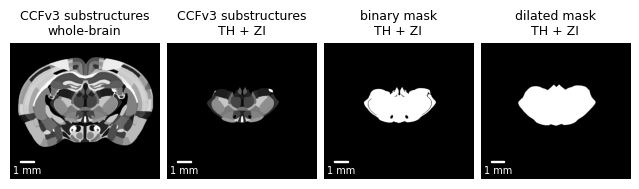

In [11]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

zindex = 36 

# display the subsetted image volume and TH+ZI binary mask
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
xy_labels = 'resampled pixels (1px=10um)'
axes = axes.ravel()

axes[0].imshow(ccf_img[:,:,zindex].T, cmap='gray')
axes[0].set_title('CCFv3 substructures\nwhole-brain', fontsize=9)
# axes[0].set_xlabel(xy_labels); axes[0].set_ylabel(xy_labels)

axes[1].imshow(th_zi_img[:,:,zindex].T, cmap='gray')
axes[1].set_title('CCFv3 substructures\nTH + ZI', fontsize=9)
# axes[1].set_xlabel(xy_labels)

axes[2].imshow(th_zi_mask[:,:,zindex].T, cmap='gray')
axes[2].set_title('binary mask\nTH + ZI', fontsize=9)
# axes[2].set_xlabel(xy_labels)

axes[3].imshow(th_zi_mask_dilated[:,:,zindex].T, cmap='gray')
axes[3].set_title('dilated mask\nTH + ZI', fontsize=9)
# axes[3].set_xlabel(xy_labels)

for ax in axes:
    ax.set_ylim(top=100)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    scalebar = AnchoredSizeBar(ax.transData,
                            100, '1 mm', 'lower left', 
                            pad=0.2,
                            sep=3,
                            color='white',
                            frameon=False,
                            size_vertical=10,
                            fontproperties=fm.FontProperties(size=7),
                            )
    ax.add_artist(scalebar)
plt.subplots_adjust(wspace=0.05)
plt.show()


fig.savefig(f'{results_dir}/fig0A_subset_by_ccf.pdf',
            transparent=True, bbox_inches='tight', dpi=1200)

In [12]:
# clean up the binary mask to remove small, erroneous mask regions
th_zi_mask_dilated_clean = cimg.cleanup_mask_regions(th_zi_mask_dilated, 
                                                     area_ratio_thresh=0.1)

### Filtering by cell types

In [13]:
# label cells that fall within the TH+ZI mask
field_name='TH_ZI_dataset'
coords = ['x_reconstructed','y_reconstructed','z_reconstructed']
resolutions = np.array([10e-3, 10e-3, 200e-3])
cells_df[field_name] = th_zi_mask_dilated_clean[cimg.image_index_from_coords(cells_df[coords], resolutions)]
# cells_df = abc_load_base._label_masked_cells(cells_df, th_zi_mask_dilated, coords, resolutions, field_name=field_name)

# filter out cells that do not fall within the TH+ZI mask
th_zi_cells_df = cells_df[cells_df[field_name]].copy().drop(columns=[field_name])

print(f'n_cells after spatial filtering: {th_zi_cells_df.shape[0]}')

n_cells after spatial filtering: 232802


In [14]:
def plot_th_mask_with_cell_overlay(cell_df, th_mask, section, 
                                   hue_column='class', trim_to_th=True, 
                                   show_mask=True, title='', legend=True):

    # make a fixed colormap for displaying thalamus mask
    if show_mask:
        cmap_th_mask = colors.ListedColormap(['black', 'white'])
    else:
        cmap_th_mask = colors.ListedColormap(['white', 'white'])
    bounds=[0,1]
    norm = colors.BoundaryNorm(bounds, cmap_th_mask.N)

    # Create legend elements to label the cell colors
    color_col = hue_column+'_color'
    # .unique() returns hue_column & color_col values in a matched order
    categories = cell_df[hue_column].unique()
    cat_color_mapping = dict(zip(categories, cell_df[color_col].unique()))
    # sort both categories & cat_color_mapping so they appear in alpha category order in legend
    categories = sorted(categories)
    cat_color_mapping = dict(sorted(cat_color_mapping.items()))
    # create invisible objects to make legend handles
    legend_elements = [Line2D([0], [0], lw=0, marker='o', markersize=10,
                              markerfacecolor=cat_color_mapping[cat],
                              color=cat_color_mapping[cat], 
                              label=cat) 
                       for cat in cat_color_mapping]
    
    # Set up figure
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    
    curr_sec_cell_df = cell_df[(cell_df['z_reconstructed']==section)]

    ax.imshow(th_mask[:,:,int(np.rint(section/0.2))].T, extent=[0, 11, 11, 0], zorder=0,
                cmap=cmap_th_mask, norm=norm)
    sc = ax.scatter(curr_sec_cell_df['x_reconstructed'], curr_sec_cell_df['y_reconstructed'],
                    color=curr_sec_cell_df['class_color'],
                    s=2, 
                    marker='.',
                    edgecolors='none', 
                    zorder=1)
    # ax.set_title('z_section = '+str(section))

    ax.set_xlabel('x_reconstructed')
    ax.set_ylabel('y_reconstructed')
    if trim_to_th:
        x_min = 2; x_max = 9; y_min = 7.5; y_max = 3.5
        ax.set_xlim((x_min,x_max))
        ax.set_ylim((y_min,y_max))
    else:
        ax.set_xlim((0,11))
        ax.set_ylim((11,0))    
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    n_cols = 2 if len(categories) > 12 else 1
    if legend:
        ax.legend(legend_elements, categories, title='class', ncol=n_cols, 
                    loc='center left', bbox_to_anchor=(1.1,0.5))
        
    plt.suptitle(title)
    plt.show()
    
    return fig

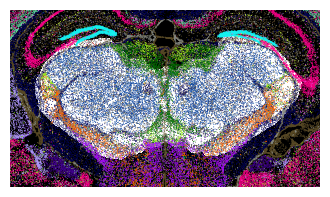

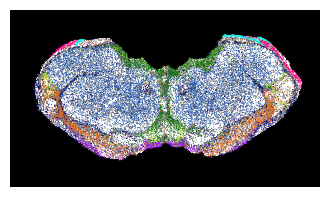

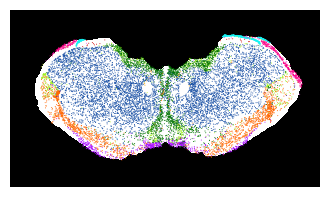

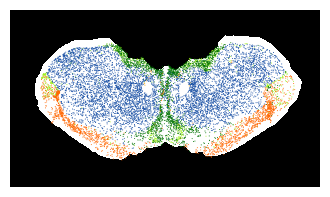

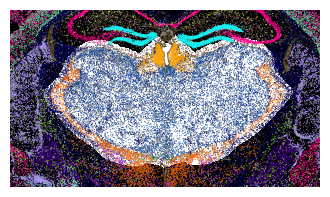

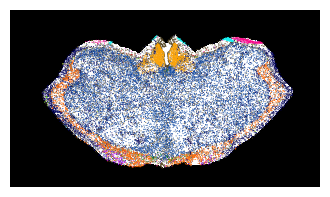

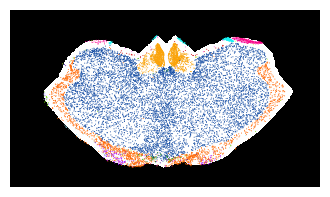

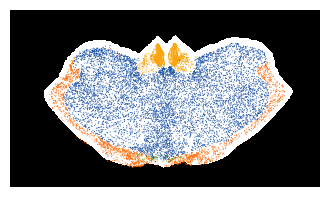

In [20]:
sections_example_2 = [6.4, 7.2]

for sec in sections_example_2:
   sec_str = str(int(sec*10))
   # All cells in ABC Atlas whole-brain dataset w/ TH mask
   fig = plot_th_mask_with_cell_overlay(cells_df, 
                                        th_zi_mask_dilated_clean, 
                                        sec, 
                                        trim_to_th=True,
                                        legend=False)
   fig.savefig(f'{results_dir}/fig0B_all_cells_with_mask_sec{sec_str}.png',
               transparent=True, bbox_inches='tight', dpi=1200)

   # All cells after filtering by TH mask
   fig = plot_th_mask_with_cell_overlay(th_zi_cells_df, 
                                        th_zi_mask_dilated_clean, 
                                        sec, 
                                        trim_to_th=True,
                                        legend=False)
   fig.savefig(f'{results_dir}/fig0B_mask_filtered_cells_sec{sec_str}.png',
               transparent=True, bbox_inches='tight', dpi=1200)

   # Neurons after filtering by TH mask + filtering out NN classes
   neurons_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES)
   fig = plot_th_mask_with_cell_overlay(neurons_test_df, 
                                        th_zi_mask_dilated_clean, 
                                        sec, 
                                        trim_to_th=True,
                                        legend=False)
   fig.savefig(f'{results_dir}/fig0B_mask_filtered_neurons_sec{sec_str}.png',
               transparent=True, bbox_inches='tight', dpi=1200)

   # TH neurons after filtering out NN, non-TH, and non-MB classes
   th_mb_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES,
                                       include=abc.TH_ZI_CLASSES+abc.MB_CLASSES)
   fig = plot_th_mask_with_cell_overlay(th_mb_test_df, 
                                        th_zi_mask_dilated_clean, 
                                        sec, 
                                        trim_to_th=True,
                                        legend=False)
   fig.savefig(f'{results_dir}/fig0B_mask_filtered_neurons_th_mb_sec{sec_str}.png',
               transparent=True, bbox_inches='tight', dpi=1200)

# fig.savefig(f'{results_dir}/fig0B_mask_filtered_neurons_th_mb_classes.pdf',
#             #  transparent=True, 
#              bbox_inches='tight', 
#              dpi=1200)

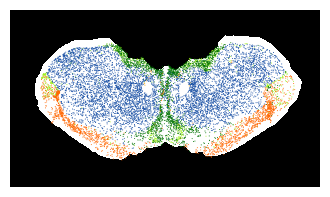

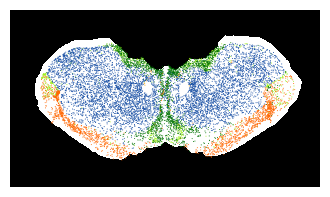

In [41]:
th_zi_neurons_df = abc.filter_by_class_thalamus(th_zi_cells_df, 
                                                filter_nonneuronal=True,
                                                filter_midbrain=False, 
                                                filter_other_nonTH=True)

plot_th_mask_with_cell_overlay(th_zi_neurons_df, 
                               th_zi_mask_dilated_clean, 
                               sections_example_2[0], 
                               trim_to_th=True, 
                               show_mask=True,
                               legend=False)

In [45]:
th_zi_neurons_df

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color,left_hemisphere,region_mask
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344101400358-4,C57BL6J-638850.33,3155,0.504776,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.441577,6.464796,5.8,...,cm,drt,ml,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC,True,True
1018093344101260463-5,C57BL6J-638850.35,2164,0.568975,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.768420,5.318179,6.2,...,lfbs,lfbst,ar,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC,False,True
1018093344101270523-5,C57BL6J-638850.33,4717,0.504824,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.108566,5.071238,5.8,...,MB,APN,APN,#FFFFFF,#BFDAE3,#FF64FF,#FF90FF,#FF90FF,True,True
1019171907102970225,C57BL6J-638850.37,3155,0.515042,C57BL6J-638850,C57BL6J-638850,wt/wt,M,6.852032,6.459106,6.6,...,HY,ZI,ZI,#FFFFFF,#BFDAE3,#E64438,#F2483B,#F2483B,False,True
1018093344101260150-4,C57BL6J-638850.35,2164,0.527076,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.943076,5.432055,6.2,...,lfbs,lfbst,ar,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019171907102620076-1,C57BL6J-638850.43,1795,0.522174,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.656792,5.425699,7.8,...,TH,RT,RT,#FFFFFF,#BFDAE3,#FF7080,#FF909F,#FF909F,False,True
1020131842101890882,C57BL6J-638850.44,1796,0.539159,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.267835,5.462476,8.0,...,TH,RT,RT,#FFFFFF,#BFDAE3,#FF7080,#FF909F,#FF909F,True,True
1018093344102470409-5,C57BL6J-638850.33,5066,0.510517,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.937806,5.487021,5.8,...,TH,LGd,LGd-sh,#FFFFFF,#BFDAE3,#FF7080,#FF8084,#FF8084,False,True


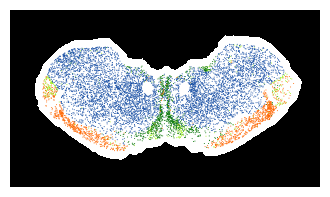

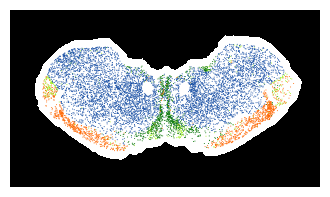

In [43]:
th_zi_neurons_df_FINAL = abc.filter_by_thalamus_coords(th_zi_neurons_df, 
                                                       buffer=0  # 0 pixels (1px=10um)
                                                       )
plot_th_mask_with_cell_overlay(th_zi_neurons_df_FINAL, 
                               th_zi_mask_dilated_clean, 
                               sections_example_2[0], 
                               trim_to_th=True, 
                               show_mask=True,
                               legend=False)

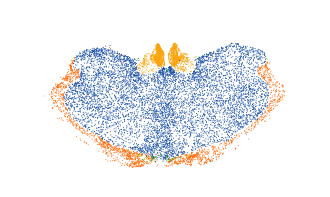

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color,left_hemisphere
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344101400358-4,C57BL6J-638850.33,3155,0.504776,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.441577,6.464796,5.8,...,fiber tracts,cm,drt,ml,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC,True
1018093344101260463-5,C57BL6J-638850.35,2164,0.568975,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.768420,5.318179,6.2,...,fiber tracts,lfbs,lfbst,ar,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC,False
1018093344101270523-5,C57BL6J-638850.33,4717,0.504824,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.108566,5.071238,5.8,...,grey,MB,APN,APN,#FFFFFF,#BFDAE3,#FF64FF,#FF90FF,#FF90FF,True
1019171907102970225,C57BL6J-638850.37,3155,0.515042,C57BL6J-638850,C57BL6J-638850,wt/wt,M,6.852032,6.459106,6.6,...,grey,HY,ZI,ZI,#FFFFFF,#BFDAE3,#E64438,#F2483B,#F2483B,False
1018093344101260150-4,C57BL6J-638850.35,2164,0.527076,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.943076,5.432055,6.2,...,fiber tracts,lfbs,lfbst,ar,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019171907102620076-1,C57BL6J-638850.43,1795,0.522174,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.656792,5.425699,7.8,...,grey,TH,RT,RT,#FFFFFF,#BFDAE3,#FF7080,#FF909F,#FF909F,False
1020131842101890882,C57BL6J-638850.44,1796,0.539159,C57BL6J-638850,C57BL6J-638850,wt/wt,M,4.267835,5.462476,8.0,...,grey,TH,RT,RT,#FFFFFF,#BFDAE3,#FF7080,#FF909F,#FF909F,True
1018093344102470409-5,C57BL6J-638850.33,5066,0.510517,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.937806,5.487021,5.8,...,grey,TH,LGd,LGd-sh,#FFFFFF,#BFDAE3,#FF7080,#FF8084,#FF8084,False


In [55]:
th_zi_neurons_df_FINAL_buffer, mask = abc.filter_by_thalamus_coords(
                                                       th_zi_neurons_df.copy(), 
                                                       buffer=1  # 0 pixels (1px=10um)
                                                       )
plot_th_mask_with_cell_overlay(th_zi_neurons_df_FINAL_buffer, 
                               mask, 
                               sections_example_2[1], 
                               trim_to_th=True, 
                               show_mask=True,
                               legend=False)
th_zi_neurons_df_FINAL_buffer

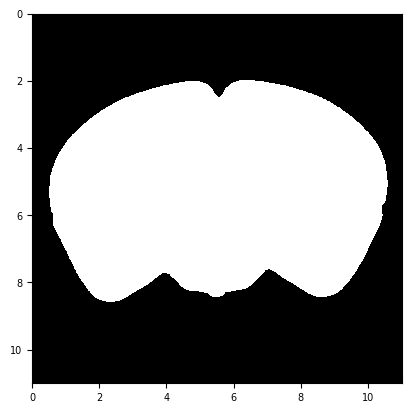

In [57]:
cmap_th_mask = colors.ListedColormap(['black', 'white'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap_th_mask.N)

plt.imshow(mask[:,:,int(np.rint(sections_example_2[0]/0.2))].T, 
           extent=[0, 11, 11, 0], 
           zorder=0,
           cmap=cmap_th_mask, 
           norm=norm)

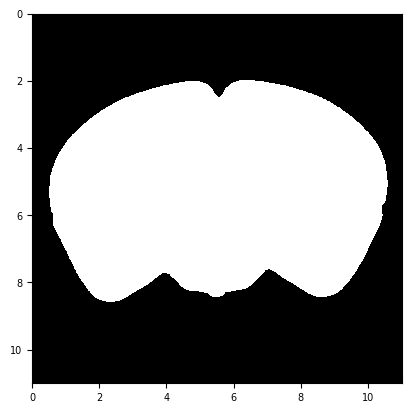

In [58]:
obs, mask = abc.filter_by_ccf_region(th_zi_neurons_df.copy(), ['TH', 'ZI'], buffer=1)

cmap_th_mask = colors.ListedColormap(['black', 'white'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap_th_mask.N)

plt.imshow(mask[:,:,int(np.rint(sections_example_2[0]/0.2))].T, 
           extent=[0, 11, 11, 0], 
           zorder=0,
           cmap=cmap_th_mask, 
           norm=norm)

In [ ]:
th_zi_neurons_df_FINAL_buffer

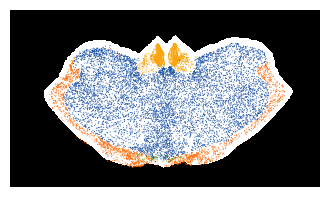

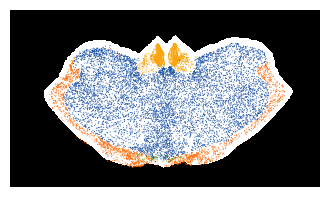

In [35]:
th_zi_neurons_df_FINAL_buffer = abc.filter_by_thalamus_coords(
                                                       th_zi_neurons_df, 
                                                       buffer=20  # 0 pixels (1px=10um)
                                                       )
plot_th_mask_with_cell_overlay(th_zi_neurons_df_FINAL_buffer, 
                               th_zi_mask_dilated_clean, 
                               sections_example_2[1], 
                               trim_to_th=True, 
                               show_mask=True,
                               legend=False)